## Molecular Geometry Recognition with PCA/t-SNE and K-Means Clustering
During the unbiased global minimum search, thousands of initial structures are generated using various algorithms. These initial structures are first optimized using a cheap method to reduce CPU cost. The representative low-lying structures from the initial optimizations are further optimized using an expensive method to achieve higher accuracy. Such low-lying structures are manually picked based on their energetics and structural similarities. While there could be many similar or duplicated structures, it is really time-consuming to manually go through thousands of files to visualize molecular structures, extract energetics, and decide candidates for further optimizations.

In this notebook, I parsed structural and energy data from 5000 Gaussian output files (~4.7 GB) and employed K-means clustering to autoselect representative structures for further optimizations. For each structure, I calculated distances from each atom to four reference points: the molecular centroid (ctd), the closest atom to ctd (cst), the farthest atom to ctd (fct), and the farthest atom to fct (ftf). The first three moments of these four atomic distance sets were calculated to encode molecular shape. Since there are thirteen features including twelve moments and energy, Principal Component Analysis (PCA) and t-distributed stochastic neighborhood embedding (t-SNE) were applied for dimensionality reduction and data visualization. For the current dataset, t-SNE has a much better performance than PCA. The dimension-reduced dataset was partitioned into k clusters using k-means clustering. In the end, representative structures were obtained by selecting structures that are closest to each cluster center from K-means clustering.

## Outline

1. **Data preparation** <br>
    1a. Parse coordinates and energies from Gaussian output files <br>
    1b. Calculate distances to four reference points (ctd, tst, fct, ftf) <br>
    1c. Obtain first three moments of the distance sets to four reference points to encode molecular shape <br>
    1d. Create a dataframe with moments and energy data <br>
    
2. **Data exploration and visualization** <br> 

3. **Dimensionality reduction and data visualization using PCA/t-SNE** <br> 
    3a. Function to plot 2D figure <br>
    3b. Use PCA to reduce the dataset down to two dimensions to plot the result <br>
    3c. Use t-SNE to reduce the dataset down to two dimensions to plot the result <br>

4. **K-means clustering and visualization** <br>
    4a. Function to plot Inertia diagram <br>
    4b. Function to plot silhouette score <br>
    4c. Function to plot Voronoi diagram <br>
    4d. K-Means clustering on data reduced via PCA <br>
    4e. K-Means clustering on data reduced via t-SNE <br>

5. **Export coordinates of molecules that are closest to cluster centroids** <br>



In [1]:
import sys
import numpy as np
import pandas as pd  
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


%matplotlib inline
import matplotlib.pyplot as plt

### 1, Data preparation

**1a, Parse coordinates and energies from Gaussian output files** <br>

In [2]:
def parseData(i):
    log_file_path = r"GMS/temporaryJob" + str(i) + ".log"
    with open(log_file_path, "r") as file:
        content = file.readlines()

    # obtain optimized coordinates and energy if possible; otherwise take input coordinates and set energy = 0
    input_coordinates = []
    optimized_coordinates = []
    energy = 0
    for i in range(len(content))[::-1]:
        if 'Standard orientation' in content[i]:
            optimized_coordinates = content[i+5:i+13]
        if 'Symbolic' in content[i]:
            input_coordinates = content[i+1:i+9]
        if 'E(UPBE1PBE)' in content[i]:
            energy = float(content[i][27:41])
        if (optimized_coordinates != [] ) and (energy != 0):
            break

    coordinates = []
    if optimized_coordinates != []:
        for item in optimized_coordinates:
            new_item = []
            for value in item.split()[3:6]:
                new_item.append(float(value))
            coordinates.append(new_item)
    else:
        for item in input_coordinates:
            new_item = []
            for value in item.split()[1:4]:
                new_item.append(float(value))
            coordinates.append(new_item)
        
    return np.array(coordinates), energy

In [3]:
parseData(1)

(array([[ 0.008321, -1.189844, -1.010845],
        [ 2.275578, -1.031223,  0.37209 ],
        [ 1.05419 ,  1.602626,  0.692867],
        [-5.183024, -0.344293,  0.112248],
        [ 1.478654,  4.175201, -0.355152],
        [-2.72487 , -0.521493, -1.075404],
        [ 4.099707, -2.371056, -0.766906],
        [ 0.090029, -1.38828 ,  1.723854]]), -925.254688299)

In [4]:
arr_coor, _ = parseData(1)

**1b, Calculate distances to four reference points (ctd, tst, fct, ftf)** <br>

In [5]:
def getDistances(arr):    
    # obtain distances to the molecular centroid (ctd), the closest atom to ctd (cst), the farthest atom to ctd (fct), and the farthest atom to fct (ftf)
    ctd = np.average(arr, axis=0)
    
    distances = []
    for item in arr:
        distances.append(np.linalg.norm(item-ctd))
    tst = arr[distances.index(min(distances))]
    fct = arr[distances.index(max(distances))]
    
    distances = []
    for item in arr:
        distances.append(np.linalg.norm(item-fct))
    ftf = arr[distances.index(max(distances))]
    
    arr_refs = np.array([ctd, tst, fct, ftf])

    distances_to_refs = []
    for point in arr:
        for ref in arr_refs:
            distances_to_refs.append(np.linalg.norm(point-ref))

    return np.array(distances_to_refs).reshape((8, 4))

In [6]:
getDistances(arr_coor)

array([[1.44154299, 0.        , 5.37832291, 4.26546685],
       [2.35509368, 2.66047442, 7.49467374, 2.53375432],
       [2.09516006, 3.43429254, 6.55975994, 5.21500332],
       [5.32665043, 5.37832291, 0.        , 9.54200057],
       [4.52380269, 5.60138557, 8.06363705, 7.06349353],
       [3.06887891, 2.81446158, 2.73577013, 7.07749288],
       [4.60843277, 4.26546685, 9.54200057, 0.        ],
       [2.16382909, 2.74310621, 5.61179746, 4.82154039]])

In [7]:
arr_distances_to_refs = getDistances(arr_coor)

**1c, Obtain first three moments of the distance sets to four reference points to encode molecular shape** <br>
These geometrical shape descriptors is proposed by PEDRO J. BALLESTER and W. GRAHAM RICHARDS in J Comput Chem 28: 1711–1723, 2007

In [8]:
def getMoments(arr):
    moments = stats.describe(arr)
    return np.array([moments.mean, moments.variance, moments.skewness]).transpose().reshape(12)

In [9]:
getMoments(arr_distances_to_refs)

array([ 3.19792383,  2.05375656,  0.32780411,  3.36218876,  3.19712772,
       -0.49675444,  5.67324522,  9.3842825 , -0.68885316,  5.06484398,
        8.69572778, -0.24289375])

**1d, Create a dataframe with moments and energy data** <br>
Combine functionals in sections 1-3 to return a list of twelve moments and energy, transfer moments and energy data to a dataframe, save it to a CSV file

In [10]:
def getFeatures(i):
    arr_coor, energy = parseData(i)
    arr_dis_to_refs = getDistances(arr_coor)
    moments = getMoments(arr_dis_to_refs)
    moments_list = moments.tolist()
    moments_list.append(energy)
    return moments_list

In [11]:
getFeatures(1)

[3.197923827817288,
 2.053756557879108,
 0.3278041119657398,
 3.36218875827985,
 3.197127721816542,
 -0.49675444243575206,
 5.673245224804817,
 9.384282500842232,
 -0.6888531574661915,
 5.064843983050167,
 8.695727775145022,
 -0.24289375045618458,
 -925.254688299]

In [12]:
def getDataset(m):
    data = []
    for i in range(1, m + 1):
        data.append(getFeatures(i))
    return data

In [13]:
getDataset(2)

[[3.197923827817288,
  2.053756557879108,
  0.3278041119657398,
  3.36218875827985,
  3.197127721816542,
  -0.49675444243575206,
  5.673245224804817,
  9.384282500842232,
  -0.6888531574661915,
  5.064843983050167,
  8.695727775145022,
  -0.24289375045618458,
  -925.254688299],
 [2.645990904169348,
  0.6204866037326221,
  -0.5354785752359359,
  2.7821841386795243,
  1.755233990830082,
  -0.9279152497361534,
  4.1800963079459095,
  3.942679495648829,
  -1.210352268001801,
  3.6191399161471125,
  3.5297641642790536,
  -0.6779571672922207,
  -925.274154784]]

In [14]:
total_data = getDataset(5000)
df = pd.DataFrame(total_data, columns = ['ctd-u1', 'ctd-u2', 'ctd-u3', 'cst-u1', 'cst-u2', 'cst-u3', 'fct-u1', 'fct-u2', 'fct-u3', 'ftf-u1', 'ftf-u2', 'ftf-u3', 'energy'])

In [15]:
df.head()

,ctd-u1,ctd-u2,ctd-u3,cst-u1,cst-u2,cst-u3,fct-u1,fct-u2,fct-u3,ftf-u1,ftf-u2,ftf-u3,energy
0,3.197924,2.053757,0.327804,3.362189,3.197128,-0.496754,5.673245,9.384283,-0.688853,5.064844,8.695728,-0.242894,-925.254688
1,2.645991,0.620487,-0.535479,2.782184,1.755234,-0.927915,4.180096,3.942679,-1.210352,3.619140,3.529764,-0.677957,-925.274155
2,3.542624,1.913443,0.575070,3.659708,3.118637,-1.027733,6.564596,12.050823,-0.915856,4.584369,9.157299,0.300333,-925.168849
3,2.383727,0.628125,-0.683417,2.526887,1.307143,-1.285009,3.648823,3.060446,-1.160373,3.519129,3.194952,-0.772761,-925.449594
4,3.101969,1.555439,0.038755,3.314306,2.739704,-0.813368,5.157009,9.266998,-0.379333,4.538512,8.071246,0.015897,-925.222121


In [16]:
df.to_csv('coordinates_energy.csv', index=False)

### 2, Data exploration and visualization
Reset index to match Gaussian output file name, generate descriptive statistics, draw histograms of all the columns, filter structures with relative energy above 1.5 eV

In [17]:
df = pd.read_csv('coordinates_energy.csv')

In [18]:
df.head()

,ctd-u1,ctd-u2,ctd-u3,cst-u1,cst-u2,cst-u3,fct-u1,fct-u2,fct-u3,ftf-u1,ftf-u2,ftf-u3,energy
0,3.197924,2.053757,0.327804,3.362189,3.197128,-0.496754,5.673245,9.384283,-0.688853,5.064844,8.695728,-0.242894,-925.254688
1,2.645991,0.620487,-0.535479,2.782184,1.755234,-0.927915,4.180096,3.942679,-1.210352,3.619140,3.529764,-0.677957,-925.274155
2,3.542624,1.913443,0.575070,3.659708,3.118637,-1.027733,6.564596,12.050823,-0.915856,4.584369,9.157299,0.300333,-925.168849
3,2.383727,0.628125,-0.683417,2.526887,1.307143,-1.285009,3.648823,3.060446,-1.160373,3.519129,3.194952,-0.772761,-925.449594
4,3.101969,1.555439,0.038755,3.314306,2.739704,-0.813368,5.157009,9.266998,-0.379333,4.538512,8.071246,0.015897,-925.222121


In [19]:
# match index with job name
df.index = np.arange(1, len(df) + 1)

In [20]:
df.head()

,ctd-u1,ctd-u2,ctd-u3,cst-u1,cst-u2,cst-u3,fct-u1,fct-u2,fct-u3,ftf-u1,ftf-u2,ftf-u3,energy
1,3.197924,2.053757,0.327804,3.362189,3.197128,-0.496754,5.673245,9.384283,-0.688853,5.064844,8.695728,-0.242894,-925.254688
2,2.645991,0.620487,-0.535479,2.782184,1.755234,-0.927915,4.180096,3.942679,-1.210352,3.619140,3.529764,-0.677957,-925.274155
3,3.542624,1.913443,0.575070,3.659708,3.118637,-1.027733,6.564596,12.050823,-0.915856,4.584369,9.157299,0.300333,-925.168849
4,2.383727,0.628125,-0.683417,2.526887,1.307143,-1.285009,3.648823,3.060446,-1.160373,3.519129,3.194952,-0.772761,-925.449594
5,3.101969,1.555439,0.038755,3.314306,2.739704,-0.813368,5.157009,9.266998,-0.379333,4.538512,8.071246,0.015897,-925.222121


In [21]:
df.describe()

,ctd-u1,ctd-u2,ctd-u3,cst-u1,cst-u2,cst-u3,fct-u1,fct-u2,fct-u3,ftf-u1,ftf-u2,ftf-u3,energy
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.124392,1.725941,-0.029429,3.233489,2.926053,-0.625163,5.345278,9.047127,-0.640276,4.714558,8.178172,-0.209632,-922.640277
std,0.404011,0.988271,0.478698,0.393653,1.249916,0.460052,0.892157,3.981747,0.258820,0.763998,3.760549,0.307291,44.854463
min,2.193434,0.090804,-2.175120,2.235732,0.878176,-2.237200,3.135145,2.299441,-1.800424,3.004318,2.168807,-1.185988,-925.458391
25%,2.860076,1.100513,-0.319451,2.971054,2.189083,-0.876506,4.766994,6.364484,-0.818096,4.186743,5.663028,-0.415231,-925.229774
50%,3.084884,1.548494,0.004159,3.207453,2.745461,-0.611090,5.282120,8.223915,-0.630808,4.650723,7.421958,-0.200026,-925.173651
75%,3.360222,2.156028,0.301182,3.464987,3.410114,-0.324313,5.888275,10.930872,-0.449249,5.168016,9.893112,-0.004107,-925.125889
max,8.403546,34.349239,1.727954,7.994534,45.838898,1.022651,21.015859,80.518214,0.037532,13.807267,84.331623,0.794778,195.070405


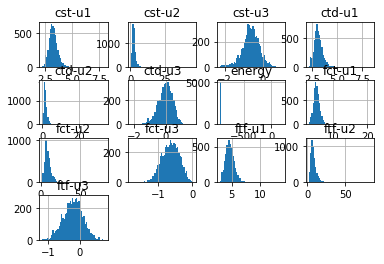

In [22]:
df.hist(bins=50)
plt.show()

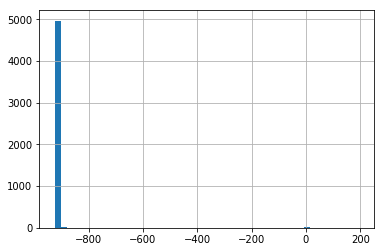

In [23]:
# the distribution of energy data is abnormal, indicating the existence of outliers
df['energy'].hist(bins=50)
plt.show()

In [24]:
# filter structures with energies 1.5 eV (0.55 hartree) higher, as they are too high too be oserved in our experiments
df1 = df[df['energy'] < (-925.458391 + 0.055)]

In [25]:
df1.describe()

,ctd-u1,ctd-u2,ctd-u3,cst-u1,cst-u2,cst-u3,fct-u1,fct-u2,fct-u3,ftf-u1,ftf-u2,ftf-u3,energy
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,2.450611,0.792540,-0.528699,2.577647,1.468393,-1.154835,3.954793,4.127484,-0.873456,3.549351,3.631385,-0.512046,-925.442282
std,0.134619,0.341199,0.584035,0.121255,0.395692,0.616623,0.574585,1.470006,0.181567,0.304402,1.089699,0.335612,0.015879
min,2.309091,0.491351,-1.914585,2.363681,0.926831,-2.222823,3.307538,2.749756,-1.220623,3.004318,2.168807,-1.058328,-925.458391
25%,2.342330,0.573926,-0.844085,2.496981,1.199088,-1.553556,3.555421,3.097571,-0.951797,3.364435,2.784472,-0.789769,-925.456709
50%,2.413568,0.671131,-0.539098,2.558387,1.386568,-1.181344,3.696833,3.340439,-0.917673,3.494880,3.336231,-0.570141,-925.448843
75%,2.540851,0.882612,-0.115731,2.634797,1.590349,-0.775375,4.150450,4.798780,-0.754242,3.680844,4.318485,-0.336307,-925.429230
max,2.903043,2.383720,0.903028,2.997938,2.969996,-0.038913,5.427180,9.513115,-0.284879,5.217143,9.319861,0.375247,-925.404608


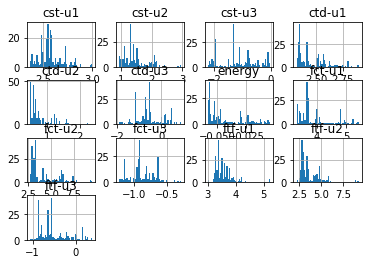

In [26]:
df1.hist(bins=50)
plt.show()

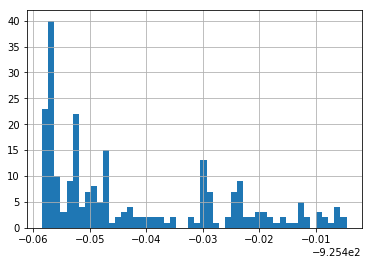

In [27]:
df1['energy'].hist(bins=50)
plt.show()

### 3, Dimensionality reduction and data visualization using PCA/t-SNE
Clearly, t-SNE has a much better performance than PCA for the current dataset.

**3a. Function to plot 2D figure** <br>

In [28]:
# plot 2D figure
def plot2D(data, name):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    marker_size=5
    plt.scatter(data[:, 0], data[:, 1], marker_size)
    plt.title("Data reduced via " + name, fontsize=14)
    plt.xlabel(name + " compoent 1", fontsize=14)
    plt.ylabel(name + " compoent 2", fontsize=14)
    plt.show()

**3b. Use PCA to reduce the dataset down to two dimensions to plot the result** <br>

In [29]:
# minimum number of dimensions required to preserve 95% of the training set’s variance:
pca = PCA()
pca.fit(df1)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [30]:
d

2

In [31]:
pca = PCA(n_components=2)
data_reduced_pca = pca.fit_transform(df1)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.91096041 0.04553088]


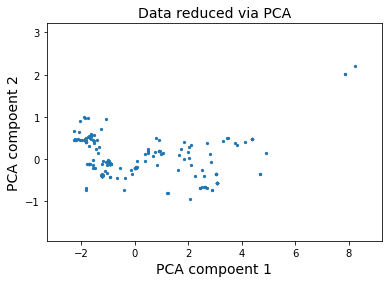

In [32]:
plot2D(data_reduced_pca, 'PCA')

**3c. Use t-SNE to reduce the dataset down to two dimensions to plot the result** <br>

In [33]:
tsne = TSNE(n_components=2, random_state=42)
data_reduced_tsne = tsne.fit_transform(df1)

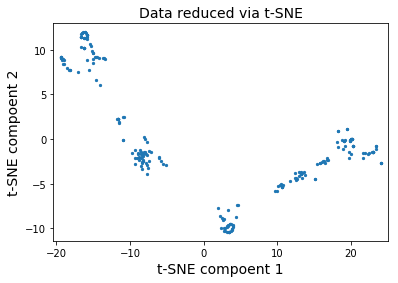

In [34]:
plot2D(data_reduced_tsne, 't-SNE')

### 4, K-means clustering and visualization

**4a. Function to plot Inertia diagram** <br>

In [35]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
def plotInertia(inertias, k, m):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, k + 1), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    plt.annotate('Elbow',
                 xy=(m, inertias[m - 1]),
                 xytext=(0.55, 0.55),
                 textcoords='figure fraction',
                 fontsize=16,
                 arrowprops=dict(facecolor='black', shrink=0.1)
                )
    plt.axis([-1, k+1, -0.1*inertias[0], 1.1*inertias[0]])
    plt.show()

**4b. Function to plot silhouette score** <br>

In [36]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
def plotSilhouette(kmeans_per_k, data_reduced, k):
    silhouette_scores = [silhouette_score(data_reduced, model.labels_) for model in kmeans_per_k[1:k]]
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, k+1), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.title('Silhouette score vs. number of clusters k')
    plt.axis([0, 41, 0.5, 0.8])
    plt.show()

**4c. Function to plot Voronoi diagram** <br>

In [37]:
# adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
def plotVoronoi(kmeans_per_k, k, X, name):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans_per_k[k-1].predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    # Plot the centroids as a white X
    centroids = kmeans_per_k[k-1].cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the ' + name + ' reduced data\n'
              '(Centroids are marked with white cross)')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(name + " compoent 1", fontsize=14)
    plt.ylabel(name + " compoent 2", fontsize=14)
    plt.show()

**4d. K-Means clustering on PCA reduced data** <br>
It is challenging to decide the apporiate number of clusters based on inertia or silhouette score.

In [38]:
kmeans_per_k_pca = [KMeans(n_clusters=k, random_state=42).fit(data_reduced_pca) for k in range(1, 41)]
inertias_pca = [model.inertia_ for model in kmeans_per_k_pca]

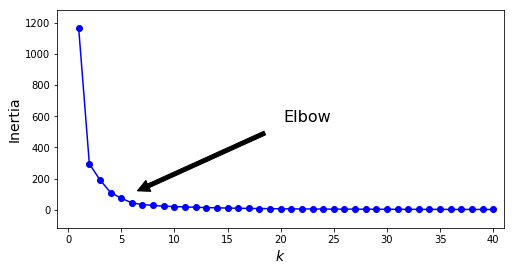

In [39]:
plotInertia(inertias_pca, 40, 5)

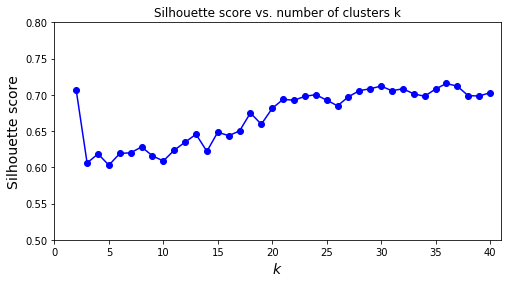

In [40]:
plotSilhouette(kmeans_per_k_pca, data_reduced_pca, 40)

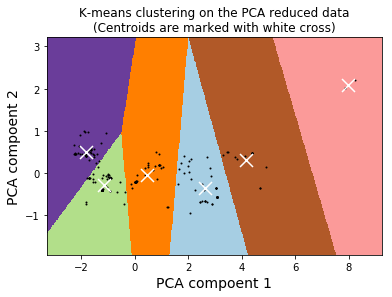

In [41]:
# Elbow point indicates number of clusters to be 6
plotVoronoi(kmeans_per_k_pca, 6, data_reduced_pca, 'PCA')

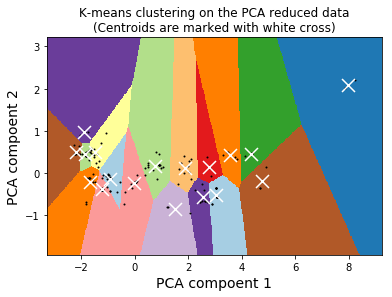

In [42]:
# Silhouette socreindicates number of clusters to be 18
plotVoronoi(kmeans_per_k_pca, 18, data_reduced_pca, 'PCA')

**4e. K-Means clustering on t-SNE reduced data** <br>
Eblow method and Silhouette score indicate 5 and 11 are good choices for number of clusters.

In [43]:
kmeans_per_k_tsne = [KMeans(n_clusters=k, random_state=42).fit(data_reduced_tsne) for k in range(1, 41)]
inertias_tsne = [model.inertia_ for model in kmeans_per_k_tsne]

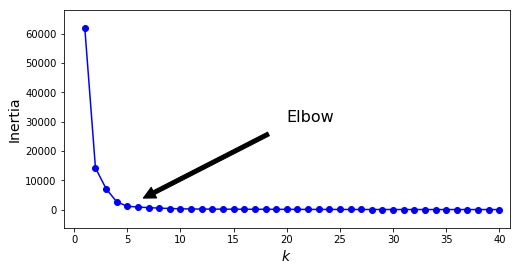

In [44]:
plotInertia(inertias_tsne, 40, 5)

/Users/cherubic/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


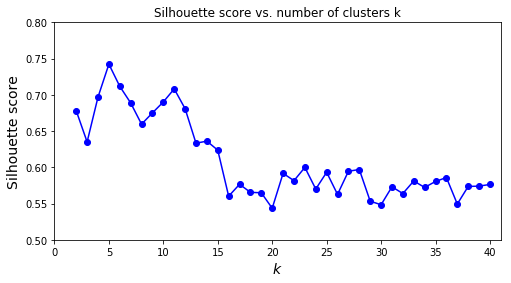

In [45]:
plotSilhouette(kmeans_per_k_tsne, data_reduced_tsne, 40)

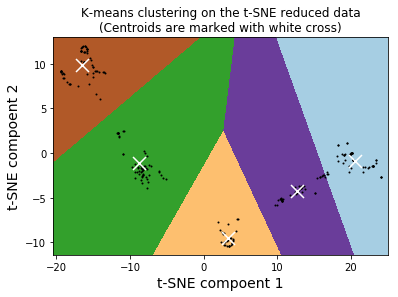

In [46]:
plotVoronoi(kmeans_per_k_tsne, 5, data_reduced_tsne, 't-SNE')

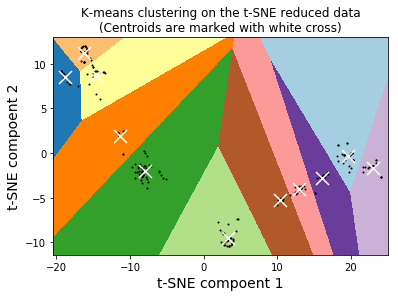

In [47]:
plotVoronoi(kmeans_per_k_tsne, 11, data_reduced_tsne, 't-SNE')

### 5, Export coordinates of molecules that are closest to cluster centroids

In [48]:
# return coordinates of representative candidates based on number of clusters
def returnCoord(kmeans_per_k, k, data_reduced, df):
    # obtain the index of molecule that is closest to a cluster centroid
    index_list = []
    for i in range(k):
        distances = []
        for j in range(len(data_reduced)):
            if kmeans_per_k[k-1].labels_[j] == i:
                distance = np.linalg.norm(data_reduced[j]-kmeans_per_k[k-1].cluster_centers_[i])
                distances.append((distance, j))
        index = df.index[distances[distances.index(min(distances))][1]]
        index_list.append(index)
    
    # extract energy and coordinates based on index
    coordinates = []
    energies = []
    for item in index_list:
        coordinate, energy = parseData(item)
        energies.append(energy)
        coordinates.append(coordinate.tolist())
        
    return index_list, energies, coordinates

**Based on the analysis from 4d and 4e, t-SNE is chosen for dimensionality reduction. For the number of clusters, 11 is prefered as it provides more diverse structures. 11 most representative structures for further optimizations are returned.** <br>

In [49]:
returnCoord(kmeans_per_k_tsne, 11, data_reduced_tsne, df1)

([2485, 4521, 1526, 2661, 4761, 2837, 1505, 4917, 3586, 71, 2018],
 [-925.430183811,
  -925.446092432,
  -925.451970605,
  -925.45698182,
  -925.444549257,
  -925.45838311,
  -925.453431547,
  -925.428715144,
  -925.411269166,
  -925.449196158,
  -925.446865043],
 [[[0.751765, -0.000305, -1.091831],
   [0.768802, -0.002407, 1.102259],
   [-0.101505, -2.491822, 0.01491],
   [-1.85322, -0.000263, 0.015979],
   [2.884527, -1.541741, -0.013734],
   [-4.496226, 0.000234, -0.023367],
   [-0.102683, 2.489309, 0.016911],
   [2.879951, 1.545691, -0.016112]],
  [[-0.150826, -0.062921, 0.366867],
   [0.262318, -0.284031, -2.005494],
   [-2.362601, -0.149756, -1.394138],
   [1.933308, 1.48454, -0.869767],
   [-0.646404, 2.490211, 0.565009],
   [1.273957, -2.383482, -0.559119],
   [-2.4567, -0.908665, 1.518777],
   [2.200577, -0.352783, 1.589664]],
  [[0.422751, 0.115794, 1.120848],
   [0.422681, 0.131342, -1.119908],
   [-1.977539, -0.846803, -0.006231],
   [1.763534, 2.331313, 0.015903],
   [2.95